In [1]:
! pip install mysql
! pip install mysql-connector-python
! pip install yfinance
! pip install -U numpy
! pip install gspread-dataframe

  Obtaining dependency information for mysql from https://files.pythonhosted.org/packages/9a/52/8d29c58f6ae448a72fbc612955bd31accb930ca479a7ba7197f4ae4edec2/mysql-0.0.3-py3-none-any.whl.metadata
  Using cached mysql-0.0.3-py3-none-any.whl.metadata (746 bytes)
  Using cached mysqlclient-2.2.4.tar.gz (90 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [30 lines of output]
      Trying pkg-config --exists mysqlclient
      /bin/sh: pkg-config: command not found
      Command 'pkg-config --exists mysqlclient' returned non-zero exit status 127.
      Trying pkg-config --exists mariadb
      /bin/sh: pkg-config: command not found
      Command 'pkg-config --exists mariadb' returned non-zero exit status 127.
      Trying pkg-config --exists libmariadb
      /bin/sh: pkg-config: command not found
      Command 'pkg-config

In [2]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:,.2f}".format
import json
import csv
import datetime
import numpy as np
import mysql.connector
from functools import lru_cache
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import warnings
warnings.filterwarnings('ignore')


import gspread
from google.oauth2.service_account import Credentials
import gspread_dataframe as gd
from functools import lru_cache

In [3]:
# เชื่อมต่อ MySQL
def get_data_sql(symbol,day):
    mydb = mysql.connector.connect(
    host="xxx",
    user="xxx",
    password="xxx",
    database="xxx",
    port=xxx
    )

    # สร้าง cursor เพื่อใช้ในการ execute คำสั่ง SQL
    mycursor = mydb.cursor()

    # คำสั่ง SQL ที่ต้องการ execute
    query = f"""

    SELECT
    DtMinOfRec,
    Last,
    Vol,
    Type,
    CASE
        WHEN Type = 'BUY' THEN 1
        WHEN Type = 'SELL' THEN -1
        ELSE 0
    END AS side

    FROM stocksm_tickmatchs
    WHERE
    Symbol = '{symbol}'
    AND Type != 'ATO/ATC'
    AND TIME(DtMinOfRec) BETWEEN '10:00:00' AND '23:59:59'
    AND Date(DtMinOfRec) >= DATE_SUB(CURRENT_DATE(), INTERVAL '{day}' DAY);

    """

    # execute คำสั่ง SQL
    mycursor.execute(query)

    # อ่านผลลัพธ์จากคำสั่ง SQL
    myresult = mycursor.fetchall()

    # รับชื่อคอลัมน์ของผลลัพธ์จากคำสั่ง SQL
    column_names = [desc[0] for desc in mycursor.description]

    # สร้าง DataFrame โดยใช้ผลลัพธ์ที่ได้จากการ query และตั้งชื่อคอลัมน์ตาม column_names
    df = pd.DataFrame(myresult, columns=column_names)

    # ปิด cursor
    mycursor.close()

    # ปิดการเชื่อมต่อ MySQL
    mydb.close()
    return df
##################################




def plotdata(symbol,day):
    df = get_data_sql(symbol,day).copy()
    df2 = df.copy()


    #################################
    #accum reset every day
    # สร้างคอลัมน์ 'Day' ในรูปแบบ '%Y-%m-%d %H:%M'
    df2['Day'] = df2['DtMinOfRec'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M'))


    df2 = df2.groupby('Day').last()


    # สร้างคอลัมน์ 'Val' โดยคูณค่า 'Last', 'Vol' และ 'side'
    df2['Last'] = pd.to_numeric(df2['Last'], errors='coerce')
    df2['Val'] = df2['Last'] * df2['Vol'] * df2['side']
    df2['Val'] = pd.to_numeric(df2['Val'], errors='coerce')
    df2['Acc Val'] = df2.groupby(df2['DtMinOfRec'].dt.date)['Val'].cumsum()
    df2['Vol Side'] =  df2['Vol'] * df2['side']
    df2['Vol Side'] = pd.to_numeric(df2['Vol Side'], errors='coerce')
    df2['Acc Vol'] = df2.groupby(df2['DtMinOfRec'].dt.date)['Vol Side'].cumsum()



    df2.index = pd.to_datetime(df2.index)

    # ตั้งค่าข้อมูลวันที่และเวลาให้อยู่ในรูปแบบที่ถูกต้อง
    df2.index = df2.index.strftime('%Y-%m-%d %H:%M')



    # สร้างรูปแบบขนาดใหญ่
    fig, ax1 = plt.subplots(figsize=(18, 10))
    ax2 = ax1.twinx()  # สร้าง Axes รองสำหรับ ax1
    ax3 = ax1.twinx()  # สร้าง Axes รองสำหรับ ax1

    # พล็อตข้อมูลสำหรับ ax1
    ax1.plot(df2.index, df2['Acc Val'], color='#753188', label='Acc Val', linewidth=2)
    ax1.set_ylabel('Acc Val', color='#753188')
    ax1.tick_params(axis='y', labelcolor='#753188')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.tick_params(axis='x', rotation=-30)


    ax1.margins(y=0.3)

    ax1.axhspan(0, 0, color='lightgray', alpha=0.5)
    ax1.axhline(0, color='#753188', linewidth=1, linestyle='--')
    ax3.axhline(0, color='#009e73', linewidth=1, linestyle='--')




    # พล็อตข้อมูลสำหรับ ax2
    ax2.plot(df2.index, df2['Last'], color='#FF6464', label='Last', linewidth=2)
    ax2.set_ylabel('Last', color='#FF6464')
    ax2.tick_params(axis='y', labelcolor='#FF6464')
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.tick_params(axis='x', rotation=-30)

    # พล็อตข้อมูลสำหรับ ax3
    ax3.plot(df2.index, df2['Acc Vol'], color='#009e73', label='Acc Vol', linewidth=2)
    ax3.set_ylabel('Acc Vol', color='#009e73')
    ax3.tick_params(axis='y', labelcolor='#009e73')
    ax3.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax3.tick_params(axis='x', rotation=-30)

    # ปรับแต่งป้ายกำกับแต่ละเส้น
    ax1.legend(loc='upper left', fontsize=12)
    ax2.legend(loc='upper center', fontsize=12)
    ax3.legend(loc='upper right', fontsize=12)

    # ปรับแต่งแกน y ให้แสดงค่าที่มีลักษณะตัวเลขเป็นจำนวนเต็มและมีลูกน้ำหลักพัน
    ax1.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,.0f}".format(x)))
    ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,.2f}".format(x)))  # ตั้งค่าทศนิยม 2 ตำแหน่ง

    ax3.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,.0f}".format(x)))

    # เพิ่มป้ายกำกับแกน x
    ax1.set_xlabel('Date', fontsize=12)
    ax1.tick_params(axis='x', labelrotation=45)

    # เพิ่มป้ายกำกับแกน y ให้แต่ละแกน
    ax1.set_xlabel('Acc Val', fontsize=12, color='#007acc')
    ax2.set_ylabel('Last', fontsize=12, color='#FF6464')
    ax3.set_ylabel('Acc Vol', fontsize=12, color='#009e73')

    # เพิ่มเส้น grid ในพื้นหลัง
    ax1.grid(True, linestyle='--', alpha=0.5)
    ax2.grid(True, linestyle='--', alpha=0.5)
    ax3.grid(True, linestyle='--', alpha=0.5)

    # แสดงกราฟ
    plt.tight_layout()
    plt.show()

    statistics_df2 = df2.describe()
    return statistics_df2

In [4]:
!pip install mysql-connector-python

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
import numpy as np
import datetime
import mysql.connector

import warnings
warnings.filterwarnings('ignore')



# เชื่อมต่อ MySQL
def get_data_sql(symbol,day):
    mydb = mysql.connector.connect(
    host="xxx",
    user="xxx",
    password="xxx",
    database="xxx",
    port=xxx
    )

    # สร้าง cursor เพื่อใช้ในการ execute คำสั่ง SQL
    mycursor = mydb.cursor()

    # คำสั่ง SQL ที่ต้องการ execute
    query = f"""

    SELECT
    DtMinOfRec,
    Last,
    Vol,
    Type,
    CASE
        WHEN Type = 'BUY' THEN 1
        WHEN Type = 'SELL' THEN -1
        ELSE 0
    END AS side

    FROM stocksm_tickmatchs
    WHERE
    Symbol = '{symbol}'
    AND Type != 'ATO/ATC'
    AND TIME(DtMinOfRec) BETWEEN '10:00:00' AND '23:59:59'
    AND Date(DtMinOfRec) >= DATE_SUB(CURRENT_DATE(), INTERVAL '{day}' DAY);

    """

    # execute คำสั่ง SQL
    mycursor.execute(query)

    # อ่านผลลัพธ์จากคำสั่ง SQL
    myresult = mycursor.fetchall()

    # รับชื่อคอลัมน์ของผลลัพธ์จากคำสั่ง SQL
    column_names = [desc[0] for desc in mycursor.description]

    # สร้าง DataFrame โดยใช้ผลลัพธ์ที่ได้จากการ query และตั้งชื่อคอลัมน์ตาม column_names
    df = pd.DataFrame(myresult, columns=column_names)

    # ปิด cursor
    mycursor.close()

    # ปิดการเชื่อมต่อ MySQL
    mydb.close()
    return df
##################################




def plotdataver2(symbol,day):
    df = get_data_sql(symbol,day).copy()
    df2 = df.copy()


    #################################
    #accum reset every day

    # สร้างคอลัมน์ 'Day' ในรูปแบบ '%Y-%m-%d %H:%M'
    df2['Day'] = df2['DtMinOfRec'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M'))


    df2 = df2.groupby('Day').last()


    df2['Last'] = pd.to_numeric(df2['Last'], errors='coerce')
    df2['Val'] = df2['Last'] * df2['Vol'] * df2['side']
    df2['Val'] = pd.to_numeric(df2['Val'], errors='coerce')

    # สร้างคอลัมน์ 'Vol Side'
    df2['Vol Side'] = df2['Vol'] * df2['side']
    df2['Vol Side'] = pd.to_numeric(df2['Vol Side'], errors='coerce')

    # คำนวณค่าสะสมโดยไม่ใช้ groupby
    df2['Acc Val'] = df2['Val'].cumsum()
    df2['Acc Vol'] = df2['Vol Side'].cumsum()



    df2.index = pd.to_datetime(df2.index)

    # ตั้งค่าข้อมูลวันที่และเวลาให้อยู่ในรูปแบบที่ถูกต้อง
    df2.index = df2.index.strftime('%Y-%m-%d %H:%M')



    # สร้างรูปแบบขนาดใหญ่
    fig, ax1 = plt.subplots(figsize=(18, 10))
    ax2 = ax1.twinx()  # สร้าง Axes รองสำหรับ ax1
    ax3 = ax1.twinx()  # สร้าง Axes รองสำหรับ ax1

    # พล็อตข้อมูลสำหรับ ax1
    ax1.plot(df2.index, df2['Acc Val'], color='#753188', label='Acc Val', linewidth=2)
    ax1.set_ylabel('Acc Val', color='#753188')
    ax1.tick_params(axis='y', labelcolor='#753188')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.tick_params(axis='x', rotation=-30)

    ax1.margins(y=0.3)
    ax1.axhspan(0, 0, color='lightgray', alpha=0.5)
    ax1.axhline(0, color='#753188', linewidth=1, linestyle='--')
    ax3.axhline(0, color='#009e73', linewidth=1, linestyle='--')




    # พล็อตข้อมูลสำหรับ ax2
    ax2.plot(df2.index, df2['Last'], color='#FF6464', label='Last', linewidth=2)
    ax2.set_ylabel('Last', color='#FF6464')
    ax2.tick_params(axis='y', labelcolor='#FF6464')
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.tick_params(axis='x', rotation=-30)

    # พล็อตข้อมูลสำหรับ ax3
    ax3.plot(df2.index, df2['Acc Vol'], color='#009e73', label='Acc Vol', linewidth=2)
    ax3.set_ylabel('Acc Vol', color='#009e73')
    ax3.tick_params(axis='y', labelcolor='#009e73')
    ax3.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax3.tick_params(axis='x', rotation=-30)

    # ปรับแต่งป้ายกำกับแต่ละเส้น
    ax1.legend(loc='upper left', fontsize=12)
    ax2.legend(loc='upper center', fontsize=12)
    ax3.legend(loc='upper right', fontsize=12)

    # ปรับแต่งแกน y ให้แสดงค่าที่มีลักษณะตัวเลขเป็นจำนวนเต็มและมีลูกน้ำหลักพัน
    ax1.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,.0f}".format(x)))
    ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,.2f}".format(x)))  # ตั้งค่าทศนิยม 2 ตำแหน่ง

    ax3.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,.0f}".format(x)))

    # เพิ่มป้ายกำกับแกน x
    ax1.set_xlabel('Date', fontsize=12)
    ax1.tick_params(axis='x', labelrotation=45)

    # เพิ่มป้ายกำกับแกน y ให้แต่ละแกน
    ax1.set_xlabel('Acc Val', fontsize=12, color='#007acc')
    ax2.set_ylabel('Last', fontsize=12, color='#FF6464')
    ax3.set_ylabel('Acc Vol', fontsize=12, color='#009e73')

    # เพิ่มเส้น grid ในพื้นหลัง
    ax1.grid(True, linestyle='--', alpha=0.5)
    ax2.grid(True, linestyle='--', alpha=0.5)
    ax3.grid(True, linestyle='--', alpha=0.5)

    # แสดงกราฟ
    plt.tight_layout()
    plt.show()


    return df2.head(60)


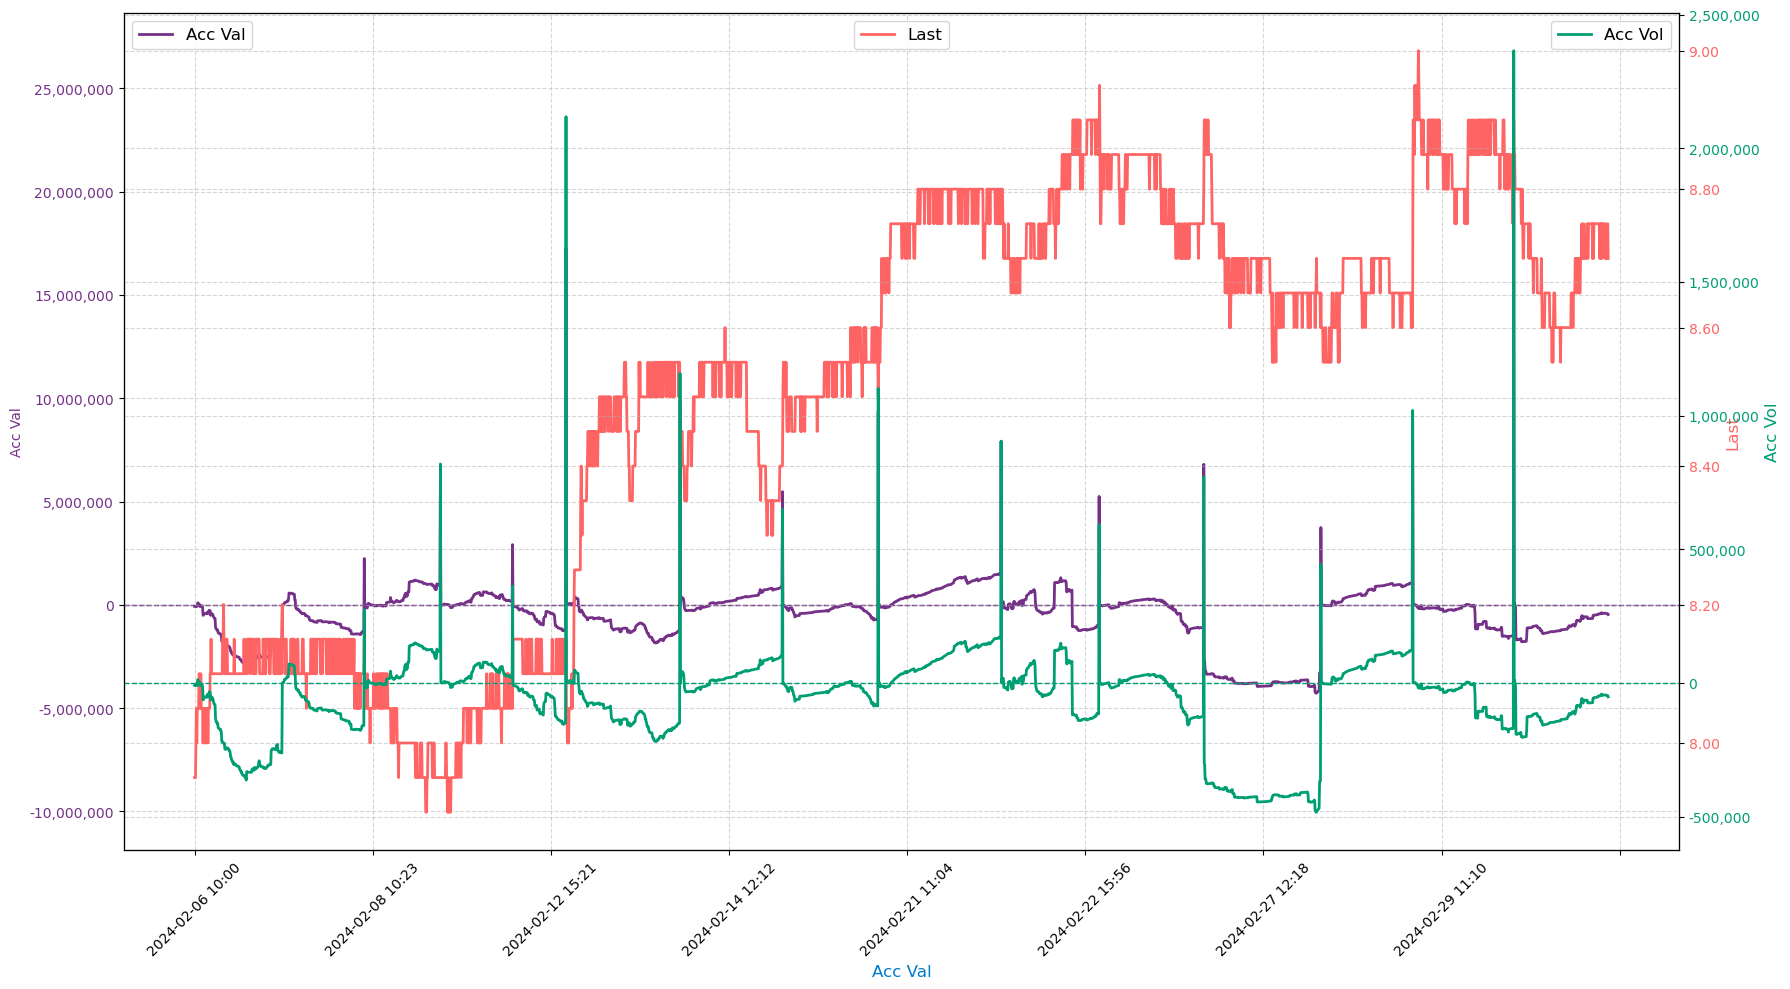

,DtMinOfRec,Last,Vol,side,Val,Acc Val,Vol Side,Acc Vol
count,3175,"3,175.00","3,175.00","3,175.00","3,175.00","3,175.00","3,175.00","3,175.00"
mean,2024-02-19 06:32:41.744881920,8.51,"6,797.39",0.30,"32,976.54","-510,930.69","3,862.46","-59,637.61"
min,2024-02-06 10:00:00,7.90,100.00,-1.00,"-2,670,000.00","-4,274,955.00","-300,000.00","-483,800.00"
25%,2024-02-12 15:04:00,8.15,200.00,-1.00,"-3,420.00","-1,127,375.00",-400.00,"-131,000.00"
50%,2024-02-21 10:51:00,8.60,500.00,1.00,"1,600.00","-190,500.00",200.00,"-22,200.00"
75%,2024-02-27 11:58:30,8.75,"2,000.00",1.00,"6,212.50","233,545.00",700.00,"26,750.00"
max,2024-03-01 16:29:00,9.00,"2,536,000.00",1.00,"22,570,400.00","21,062,205.00","2,536,000.00","2,365,200.00"
std,NaN,0.29,"77,883.27",0.95,"668,972.86","1,426,478.76","78,083.93","164,765.54"


In [5]:
symbol = 'psl'; day = 30
plotdata(symbol,day)

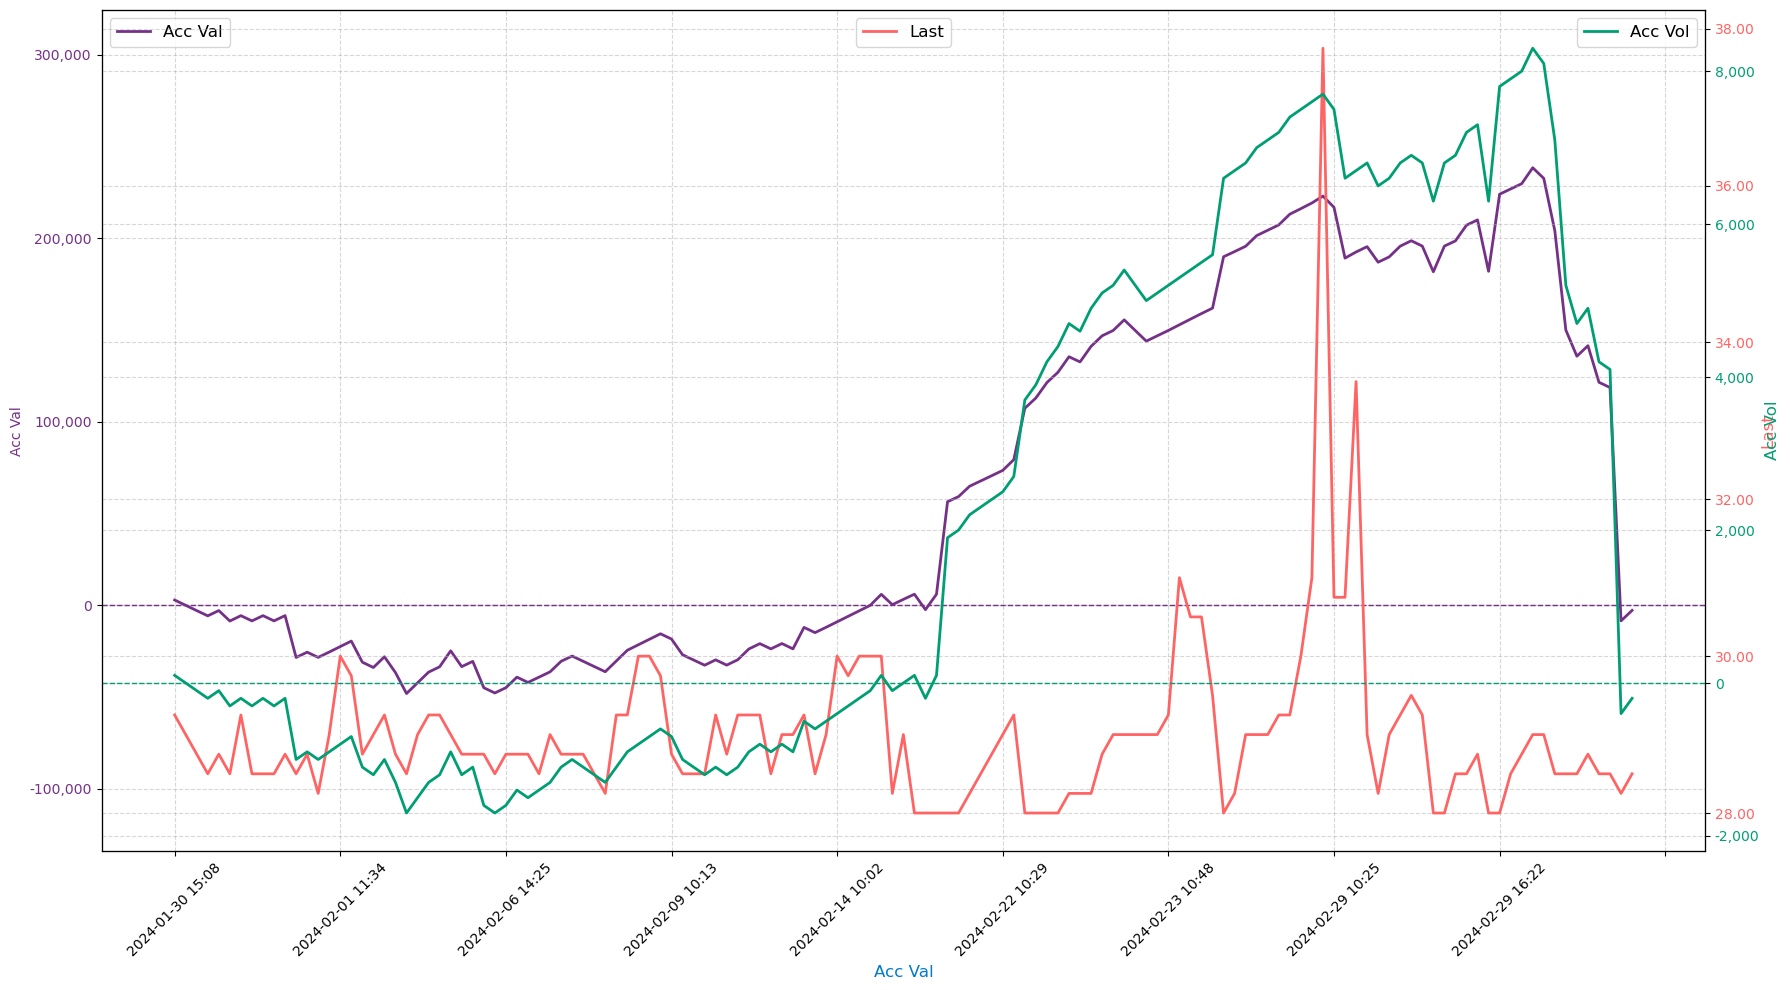

,DtMinOfRec,Last,Vol,Type,side,Val,Vol Side,Acc Val,Acc Vol
Day,,,,,,,,,
2024-01-30 15:08,2024-01-30 15:08:00,29.25,100,BUY,1,"2,925.00",100,"2,925.00",100
2024-01-30 16:10,2024-01-30 16:10:00,29.00,100,SELL,-1,"-2,900.00",-100,25.00,0
2024-01-30 16:18,2024-01-30 16:18:00,28.75,100,SELL,-1,"-2,875.00",-100,"-2,850.00",-100
2024-01-30 16:21,2024-01-30 16:21:00,28.50,100,SELL,-1,"-2,850.00",-100,"-5,700.00",-200
2024-01-30 16:22,2024-01-30 16:22:00,28.75,100,BUY,1,"2,875.00",100,"-2,825.00",-100
2024-01-30 16:27,2024-01-30 16:27:00,28.50,200,SELL,-1,"-5,700.00",-200,"-8,525.00",-300
2024-01-31 11:25,2024-01-31 11:25:00,29.25,100,BUY,1,"2,925.00",100,"-5,600.00",-200
2024-01-31 15:25,2024-01-31 15:25:00,28.50,100,SELL,-1,"-2,850.00",-100,"-8,450.00",-300
2024-01-31 15:47,2024-01-31 15:47:00,28.50,100,BUY,1,"2,850.00",100,"-5,600.00",-200


In [6]:
symbol = 'F&D'; day = 41
plotdataver2(symbol,day)